In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from scipy import stats
from matplotlib.pyplot import figure

https://dm13450.github.io/2022/02/02/Order-Flow-Imbalance.html

Terminology


bidv = volume of <b>bid</b> at n - 1 <br>
sbidv = volume of <b>bid</b> at n<br>
saskv = volume of <b>ask</b> at n - 1<br>
askv = volume of <b>ask</b> at n<br>

In [35]:
d = pd.read_pickle("data/orderbook.pkl")
d = d[d.pair == "BTC/USD"]
d = d[d.exchange == "kraken"]
d = d.drop(["pair", "exchange"], axis = 1)
d = d.rename( {"bestAskPrice":"askp", "bestAskVolume":"askv", "bestBidPrice":"bidp", "bestBidVolume":"bidv"} ,axis = 1)
d["saskp"] = d.askp.shift()
d["saskv"] = d.askv.shift()
d["sbidp"] = d.bidp.shift()
d["sbidv"] = d.bidv.shift()
d = d.dropna()
d = d.reset_index(drop = True)
d["bidpincrease"] = d.sbidp >= d.bidp
d["bidpdecrease"] = d.sbidp <= d.bidp
d["askpincrease"] = d.saskp >= d.askp
d["askpdecrease"] = d.saskp <= d.askp

d["mid"] = ( d.askp + d.bidp ) / 2
d["smid"] = ( d.saskp + d.sbidp ) / 2
d["change"] = d.smid / d.mid - 1

In [36]:
d.head()

,ts,askp,askv,bidp,bidv,saskp,saskv,sbidp,sbidv,bidpincrease,bidpdecrease,askpincrease,askpdecrease,mid,smid,change
0,2018-04-17 10:56:24,8099.0,2.469,8094.0,1.19,8099.0,0.218,8094.0,1.00,True,True,True,True,8096.50,8096.50,0.000000
1,2018-04-17 10:56:29,8098.9,0.209,8095.0,0.60,8099.0,2.469,8094.0,1.19,False,True,True,False,8096.95,8096.50,-0.000056
2,2018-04-17 10:56:35,8099.5,2.469,8095.0,0.60,8098.9,0.209,8095.0,0.60,True,True,False,True,8097.25,8096.95,-0.000037
3,2018-04-17 10:56:40,8101.6,1.000,8095.1,1.01,8099.5,2.469,8095.0,0.60,False,True,False,True,8098.35,8097.25,-0.000136
4,2018-04-17 10:56:46,8101.5,0.234,8095.1,0.01,8101.6,1.000,8095.1,1.01,True,True,True,False,8098.30,8098.35,0.000006


#### Imbalance formula from link

In theory: <br>
Best bid or size at the best bid increase -> increase in demand, buyer is ready to pay more <br>
Best bid or size at the best bid decreases -> decrease in demand, buyer is ready to pay less <br>
Best ask decreases or size at the best ask increases -> increase in supply, sellers are ready to sell more <br>
Best ask increases or size at the best ask decreases -> decrease in supply, sellers are ready to sell less <br>

In [37]:
d["imb"] = d.bidpincrease*d.sbidv - d.bidpdecrease*d.bidv  - d.askpdecrease*d.saskv + d.askpincrease*d.askv

<AxesSubplot:>

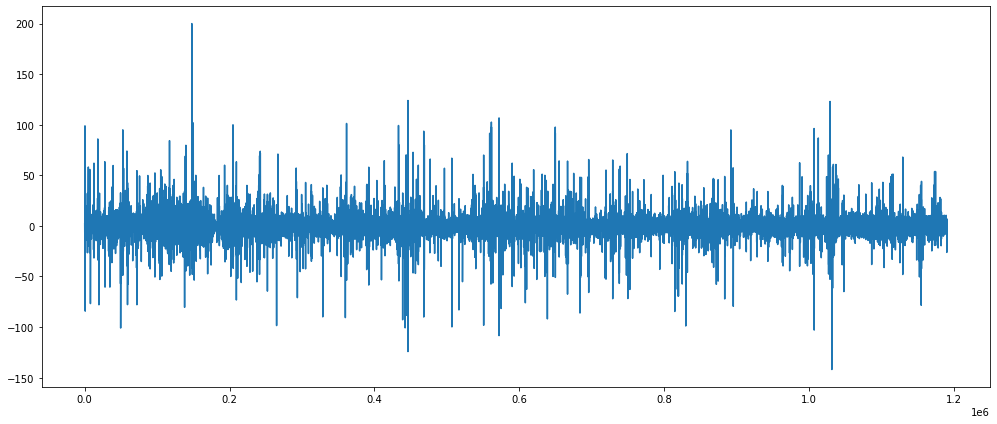

In [38]:
d.imb.plot(figsize = (17, 7))

<AxesSubplot:>

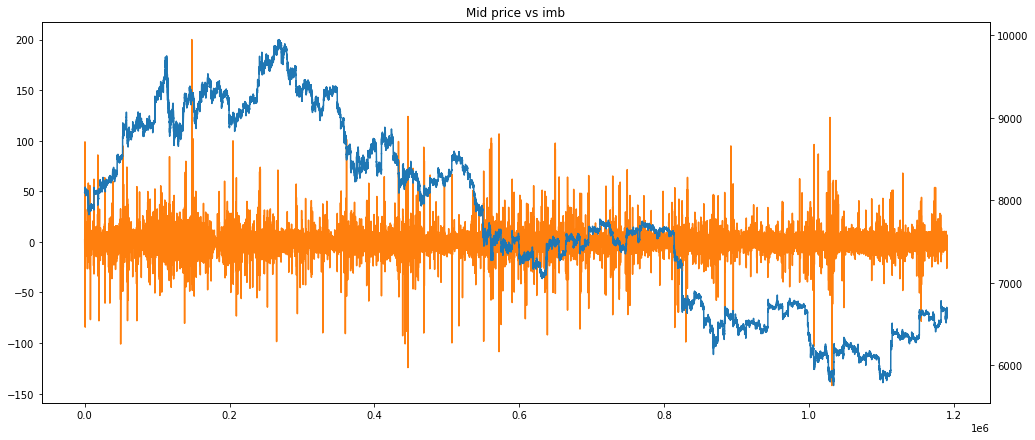

In [220]:
ax1 = d.imb.plot(figsize = (17, 7), color = '#ff7f0e', title = "Mid price vs imb")

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
d.mid.plot(ax=ax2, color = '#1f77b4')

#### Check correlations between imbalance and shifted change

This code is to research on this topic: <br>
<b>Does imbalance correlate to something else than the current snapshot? </b><br>
With potential hypothesis that markets move some time after the imbalance "happened"

In [39]:
e = d[["imb", "change"]].copy()

In [225]:
corrs = pd.read_pickle("corrs.pkl")
corrs = corrs.iloc[1:, :]
corrs["abspearson"] = np.abs(corrs.pearson)
corrs["abskendall"] = np.abs(corrs.kendall)
corrs["absspearman"] = np.abs(corrs.spearman)

In [226]:
corrs.sort_values(by=['abspearson'], ascending=False).round(2).head(2)

,column,pearson,kendall,spearman,abspearson,abskendall,absspearman
2,s2change,0.05,0.06,0.08,0.05,0.06,0.08
3,s3change,0.04,0.05,0.06,0.04,0.05,0.06


Imbalance highest correlation is to next snapshot, but it is still due to random nature of markets as it is < 0.1<br>
<b>RESULT</b>: Imbalance does not correlate with change of future market prices

### Linear regression

Research topic: <br>
<b> Does imbalance have predictive power when used in a linear model? </b>

In [227]:
e = d[["imb", "change"]].copy()
e["target"] = e.change.shift(2)
e = e[['imb', 'target']]
e = e.dropna()
e = e.reset_index(drop = True)

In [228]:
cut = int(e.shape[0]*0.7)
etrain, etest = e.iloc[:cut, :], e.iloc[cut: , :]
trainx, trainy, testx, testy = etrain.imb, etrain.target, etest.imb, etest.target
trainx, testx = trainx.values.reshape(-1, 1), testx.values.reshape(-1, 1)

In [229]:
model = LinearRegression().fit(trainx, trainy)

In [230]:
model.score(testx, testy)

0.0032573728923657175

<AxesSubplot:>

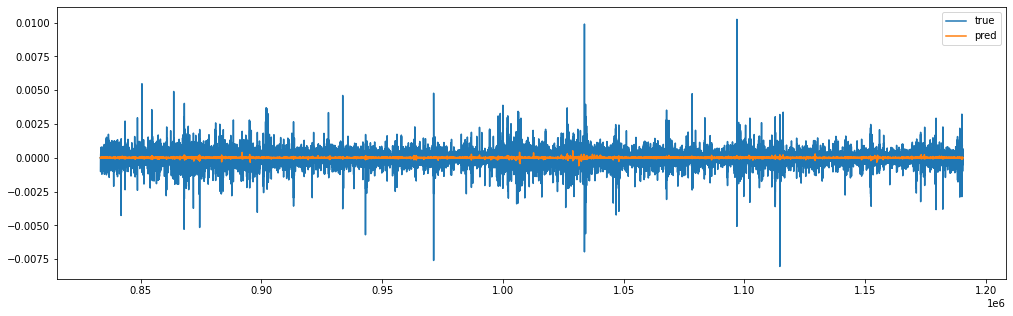

In [231]:
y_true = testy
y_pred = model.predict(testx)
pd.DataFrame({"true":y_true, "pred":y_pred})[['true', 'pred']].plot(figsize = (17,5))

With R^2 as 0.003 (0 is the lowest possible) <br>
<b>RESULT</b>: Used as this, it has zero predictive power

### Rolling mean

Research topic: <br>
<b> Which rolling mean correlates the most with next change </b>?

In [234]:
q = pd.read_pickle("q_with_500_roll_means.pkl")

In [236]:
q["schange"] = q.change.shift()
q = q.dropna()
q = q.reset_index(drop = True)

/var/folders/3n/qb9qrmdn45q_rjlp5x6g7k5c0000gn/T/ipykernel_51646/3732434677.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  q["schange"] = q.change.shift()


In [238]:
q.head()

,ts,imb,change,mid,smid,2mean,3mean,4mean,5mean,6mean,...,491mean,492mean,493mean,494mean,495mean,496mean,497mean,498mean,499mean,schange
0,2018-04-17 10:56:29,-0.391,-0.000056,8096.95,8096.50,0.8350,0.835000,0.83500,0.8350,0.835000,...,0.835000,0.835000,0.835000,0.835000,0.835000,0.835000,0.835000,0.835000,0.835000,0.000000
1,2018-04-17 10:56:35,-0.209,-0.000037,8097.25,8096.95,-0.3000,0.487000,0.48700,0.4870,0.487000,...,0.487000,0.487000,0.487000,0.487000,0.487000,0.487000,0.487000,0.487000,0.487000,-0.000056
2,2018-04-17 10:56:40,-3.479,-0.000136,8098.35,8097.25,-1.8440,-1.359667,-0.50450,-0.5045,-0.504500,...,-0.504500,-0.504500,-0.504500,-0.504500,-0.504500,-0.504500,-0.504500,-0.504500,-0.504500,-0.000037
3,2018-04-17 10:56:46,1.234,0.000006,8098.30,8098.35,-1.1225,-0.818000,-0.71125,-0.1568,-0.156800,...,-0.156800,-0.156800,-0.156800,-0.156800,-0.156800,-0.156800,-0.156800,-0.156800,-0.156800,-0.000136
4,2018-04-17 10:56:51,0.033,0.000025,8098.10,8098.30,0.6335,-0.737333,-0.60525,-0.5624,-0.125167,...,-0.125167,-0.125167,-0.125167,-0.125167,-0.125167,-0.125167,-0.125167,-0.125167,-0.125167,0.000006


In [239]:
rollmeancorrsdf = pd.read_pickle("rollmeancorrs.pkl")

In [240]:
rollmeancorrsdf["abspearson"] = np.abs(rollmeancorrsdf.pearson)
rollmeancorrsdf["abskendall"] = np.abs(rollmeancorrsdf.kendall)
rollmeancorrsdf["absspearman"] = np.abs(rollmeancorrsdf.spearman)
rollmeancorrsdf["absmeancorr"] = (rollmeancorrsdf.abspearson + rollmeancorrsdf.abskendall + rollmeancorrsdf.absspearman) / 3

In [241]:
rollmeancorrsdf.sort_values(by=['absmeancorr'], ascending=False).round(2).head(2)

,column,pearson,kendall,spearman,abspearson,abskendall,absspearman,absmeancorr
0,2mean,0.28,0.33,0.44,0.28,0.33,0.44,0.35
1,3mean,0.27,0.27,0.37,0.27,0.27,0.37,0.31


<b>RESULT</b>: Rolling mean of 2 previous values correlates the most, but correlation is still very low for predictive power

### Charts

<AxesSubplot:>

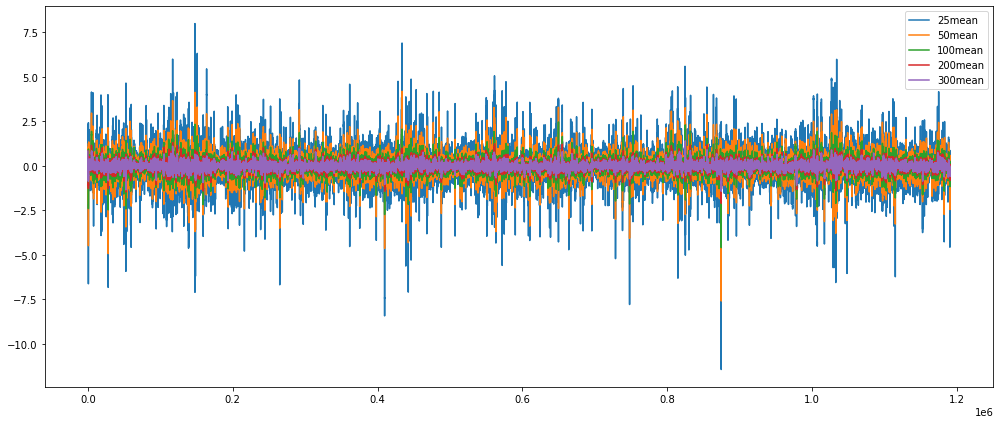

In [251]:
q[['25mean', '50mean', '100mean', '200mean', '300mean']].plot(figsize = (17, 7))

It is clear that making the mean window bigger means we get smaller values, because imbalance always jumps above or below the 0

In [260]:
q[['10mean','50mean','100mean','200mean']].describe().round(2)[1:]

,10mean,50mean,100mean,200mean
mean,-0.00,-0.00,-0.00,-0.00
std,0.76,0.38,0.28,0.20
min,-16.75,-7.59,-4.59,-2.10
25%,-0.27,-0.18,-0.14,-0.11
50%,-0.00,-0.00,-0.00,-0.00
75%,0.26,0.17,0.13,0.10
max,19.69,4.20,2.47,1.37


In [353]:
m10 = q[(np.abs(stats.zscore(q["10mean"])) >=16)].index
m10.shape

(88,)

In [350]:
m50 = q[(np.abs(stats.zscore(q["50mean"])) >= 12)].index
m50.shape

(38,)

In [358]:
m100 = q[(np.abs(stats.zscore(q["100mean"])) >= 8)].index
m100.shape

(221,)

In [365]:
m200 = q[(np.abs(stats.zscore(q["200mean"])) >= 6)].index
m200.shape

(601,)

Research topic: <br>
<b> What happens after rolling mean reaches high deviations from mean ? </b>

#### Mean 10

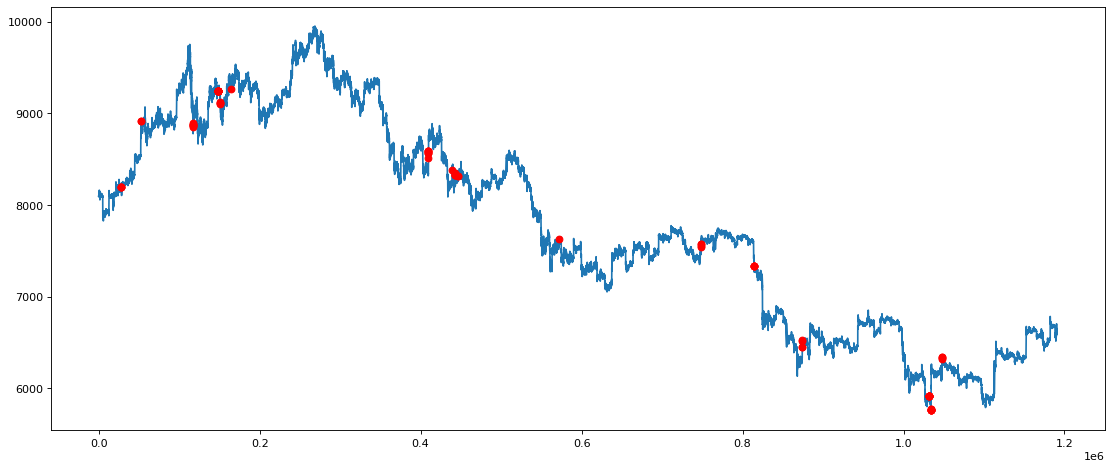

In [319]:
figure(figsize=(17, 7), dpi=80)
plt.plot(q.index, q.mid)
plt.plot(m10, q.mid[m10], 'ro')

#### Mean 50

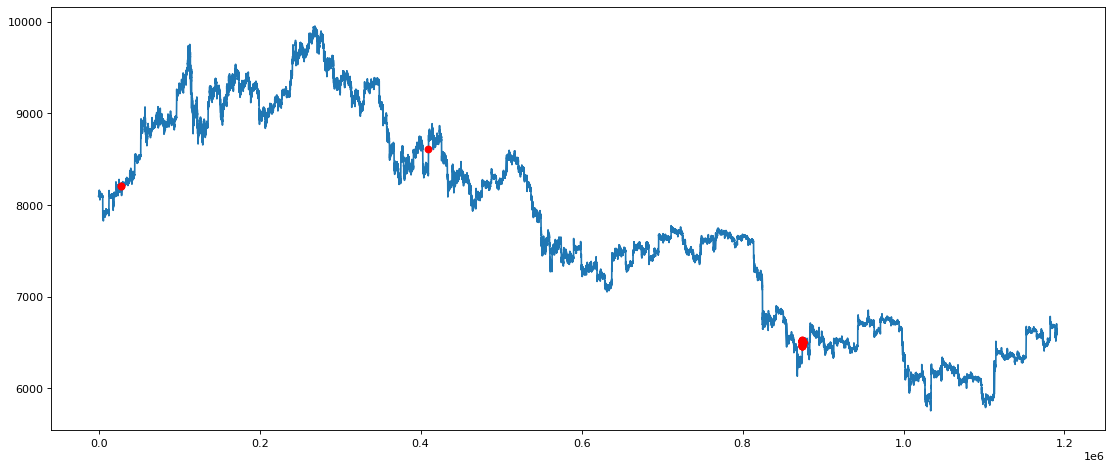

In [352]:
figure(figsize=(17, 7), dpi=80)
plt.plot(q.index, q.mid)
plt.plot(m50, q.mid[m50], 'ro')

#### Mean 100

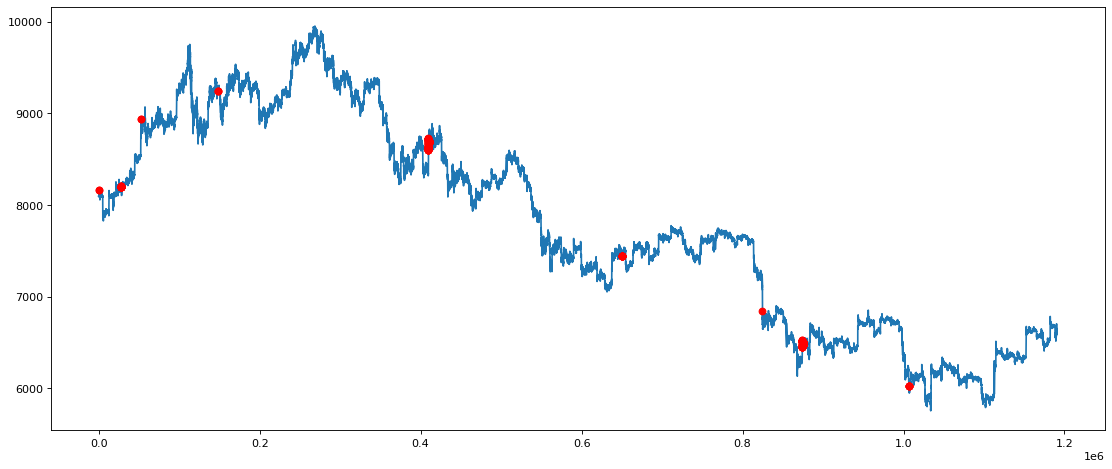

In [359]:
figure(figsize=(17, 7), dpi=80)
plt.plot(q.index, q.mid)
plt.plot(m100, q.mid[m100], 'ro')

#### Mean 200

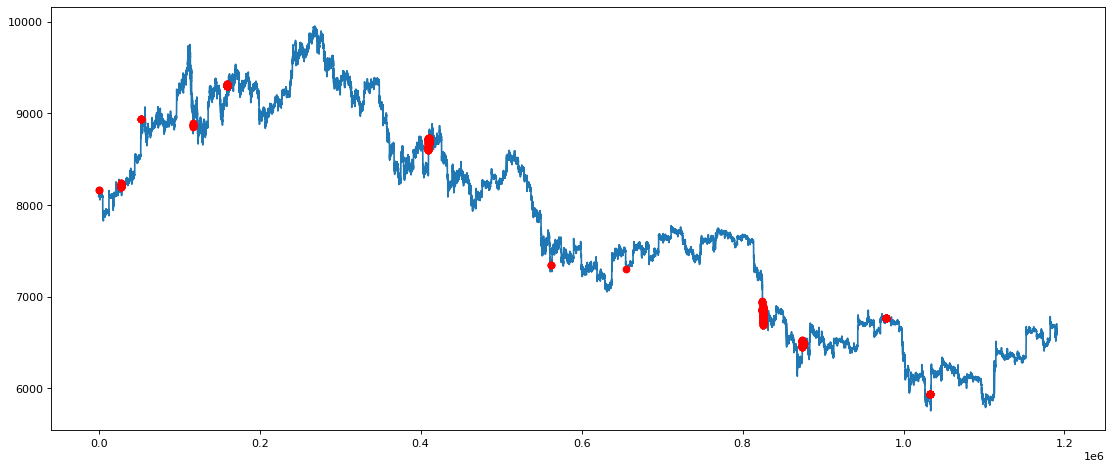

In [366]:
figure(figsize=(17, 7), dpi=80)
plt.plot(q.index, q.mid)
plt.plot(m200, q.mid[m200], 'ro')